# Causal Inference in Marketing

In [42]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, mean
from pyspark.sql.types import StructType, StructField, FloatType
from pyspark.sql.window import Window
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g --executor-memory 8g pyspark-shell"

from causalml.inference.meta import BaseTClassifier
from causalml.metrics.visualize import plot, auuc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from econml.metalearners import TLearner
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
spark = SparkSession.builder.appName("Load data").getOrCreate()
df = spark.read.csv("data/criteo-uplift-v2.1.csv", header=True, inferSchema=True)
df_10 = spark.read.csv("data/criteo-uplift-10k.csv", header=True, inferSchema=True)
n = df_10.count()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/11 01:46:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in and Prep Data

In [17]:
n = df.count()
n

13979592

In [4]:
#df_1 = df.limit(5000)
#df_2 = df.orderBy("treatment", ascending=True).limit(5000)
#df_3 = df_1.union(df_2)
#df_3 = df_3.toPandas()
#df_3 = pd.concat([df_1, df_2], axis=0)
#df_3.to_csv("data/criteo-uplift-10k.csv", index=False)

In [6]:
df.limit(3).toPandas()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [100]:
# convert categorical columns to binaries
# zip_code_dummies = pd.get_dummies(df['zip_code'], prefix='zip_code')*1
# channel_dummies = pd.get_dummies(df['channel'], prefix='channel')*1
# df = pd.concat([df, zip_code_dummies, channel_dummies], axis=1)
# df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1,0,1,0,0,1,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,1,0,0,0,0,1
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1,0,1,0,0,0,1


In [19]:
# Filter for control group and calculate visit and conversion rates
control_df = df.filter(col("treatment") == 0)
control_visit_rate = control_df.agg(mean("visit")).collect()[0][0]
control_conversion_rate = control_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Filter for treatment group and calculate visit and conversion rates
treatment_df = df.filter(col("treatment") == 1)
treatment_visit_rate = treatment_df.agg(mean("visit")).collect()[0][0]
treatment_conversion_rate = treatment_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Print the results
print(f"The control group had an {round(control_visit_rate, 4)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 4)*100}% conversion rate")
print(f"The treatment group had a {round(treatment_visit_rate, 4)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 4)*100}% conversion rate")

The control group had an 3.82% visit rate, of these visits there was a 5.07% conversion rate
The treatment group had a 4.8500000000000005% visit rate, of these visits there was a 6.36% conversion rate


In [101]:
#control_visit_rate = df.query("treatment == 0")['visit'].mean()
#control_conversion_rate = df.query("treatment == 0 and visit == 1")['conversion'].mean()
#print(f"The control group had an {round(control_visit_rate, 2)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 2)*100}% conversion rate")

#treatment_visit_rate = df.query("treatment == 1")['visit'].mean()
#treatment_conversion_rate = df.query("treatment == 1 and visit == 1")['conversion'].mean()
#print(f"The treatment group had a {round(treatment_visit_rate, 2)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 2)*100}% conversion rate")

The control group had an 11.0% visit rate, of these visits there was a 5.0% conversion rate
The treatment group had a 15.0% visit rate, of these visits there was a 6.0% conversion rate


In [51]:
print(f"control count in full data: {df.where('treatment == 0').count()}")
print(f"control count in train data: {df_train.where('treatment == 0').count()}")
print(f"control count in test data: {df_test.where('treatment == 0').count()}")

control count in full data: 2096937


control count in train data: 1467843


control count in test data: 629094


In [50]:
df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)
#features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
features = ['f1','f2','f3','f10','f11']
X_train = df_train[features]; X_test = df_test[features];
T_train = df_train[["treatment"]]; T_test = df_test[["treatment"]];
y_train = df_train[["visit"]]; y_test = df_test[["visit"]];

In [37]:
#y_train_pd = y_train.toPandas()
#T_train_pd = T_train.toPandas()
X_train_pd = X_train.toPandas()

Py4JJavaError: An error occurred while calling o490.collectToPython.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:102)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:455)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:498)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:345)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:364)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:445)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at jdk.internal.reflect.GeneratedMethodAccessor75.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [217]:
# Features, treatment, and outcome
#X = df[['recency', 'history', 'womens', 'zip_code_Rural', 'zip_code_Urban', 'channel_Web']]
#T = df['treatment']
#y = df['visit']

In [31]:
# Split the data into train and test
#X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [10]:
T_train.describe().show()

+-------+------------------+
|summary|         treatment|
+-------+------------------+
|  count|          11183688|
|   mean|0.8499596912932478|
| stddev|0.3571109433677313|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [4]:
# fit the EconML model
models = GradientBoostingRegressor(n_estimators=10, max_depth=6, min_samples_leaf=100)
t_learner_eml = TLearner(models=models)
# Train T_learner
#t_learner_eml.fit(y_train_pd, T_train_pd, X=X_train.collect())
t_learner_eml.fit(y_train.collect(), T_train.collect(), X=X_train.collect())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [25]:
# Fit the CausalML model
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
#t_learner_cml = BaseTClassifier(learner=XGBClassifier(max_depth=3, learning_rate = 0.2, reg_lambda = 0.2, random_state=42))
#t_learner_cml.fit(X_train.collect(), T_train.collect(), y_train.collect())

In [20]:
ite_test = t_learner_eml.effect(X_test.collect())
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test.toPandas()["treatment"], "ite": ite_test, "outcome": y_test.toPandas()["visit"]})
df_test.head()

,treatment,ite,outcome
0,1,0.003742,0
1,1,0.003742,0
2,1,0.003742,0
3,1,0.003742,0
4,1,0.003742,0


In [29]:
T_test["treatment"]

Column<'treatment'>

In [34]:
ite_test = t_learner_eml.effect(X_test.collect())
ite_test = [float(value[0]) for value in ite_test]
ite_schema = StructType([StructField("ite", FloatType(), True)])
df_ite = spark.createDataFrame([(v,) for v in ite_test], schema=ite_schema)
df_test = df_test.withColumn("row_index", F.monotonically_increasing_id())
df_ite = df_ite.withColumn("row_index", F.monotonically_increasing_id())
df_test_2 = df_test.join(df_ite, "row_index").drop("row_index")
df_test_2.limit(3).toPandas()

24/11/11 15:14:00 WARN TaskSetManager: Stage 22 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,ite
0,12.616365,10.059654,8.214383,4.679882,10.280525,0.346360,0.294443,10.655268,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
1,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,9.323430,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
2,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,11.244340,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742


In [53]:
df_ite = spark.createDataFrame([(v,) for v in ite_test], schema=ite_schema)
df_ite = df_ite.withColumn("row_index", F.monotonically_increasing_id())
df_test_2 = df_test.withColumn("row_index", F.monotonically_increasing_id())
df_test_2 = df_test_2.join(df_ite, "row_index").drop("row_index")
df_test_2.limit(3).toPandas()

24/11/12 05:05:05 WARN TaskSetManager: Stage 139 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,ite
0,12.616365,10.059654,8.214383,4.679882,10.280525,0.346360,0.294443,10.655268,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
1,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,9.323430,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
2,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,11.244340,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742


In [54]:
print(f"control count in test data: {df_test.where('treatment == 0').count()}")
print(f"control count in test data 2: {df_test_2.where('treatment == 0').count()}")

control count in test data: 629094


24/11/12 05:07:07 WARN TaskSetManager: Stage 147 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.


control count in test data 2: 0


## Uplift curve
Let's make the uplift curve, note while this looks similar to the AUC curve, it is different. The x-axis in this case represents the population selected for treatment. So at the origin when x = 0, this is when we do not give treatment to anybody; in contrast when x = 1, this is when we give treatment to everybody. The y-axis measures the uplift between the difference of predicted treatment and control outcomes. A standard thing to do, is to also sort the individuals so that the highest uplift individuals have their uplift recorded first (by sorting them from highest uplift to lowest) which will give the curve the concave shape when it out performs the baseline random treatment assignment model

In [38]:
# Sort the test data by uplift score in descending order
#df_test_sorted = df_test.sort_values(by='ite', ascending=False)
#df_test_sorted.head(6)
# Compute the percentage rank of the predicted uplift values in descending order, and display the top twenty rows
df_test_sorted = df_test.withColumn("percent_rank", F.percent_rank().over(Window.orderBy(F.desc("ite"))))

display(df_test_sorted.limit(10).toPandas())

24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:11 WARN TaskSetManager: Stage 27 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.
24/11/11 16:04:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:13 WARN WindowExec

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,ite,percent_rank
0,12.632704,10.059654,8.333584,2.587543,10.280525,4.115453,-3.993764,4.833815,3.920995,22.570329,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
1,12.616365,10.059654,8.837823,4.679882,10.280525,4.115453,0.294443,4.833815,3.927254,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
2,22.605250,10.059654,8.465308,4.679882,10.280525,4.115453,-9.404879,4.833815,3.835145,18.380112,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
3,23.130760,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
4,12.616365,10.059654,8.924308,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
5,22.213951,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
6,22.203386,10.059654,8.214383,4.679882,10.280525,4.115453,-8.693224,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
7,22.584338,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.172211,0.000005
8,22.500326,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.167937,0.000006
9,23.047840,10.059654,8.214383,4.679882,10.280525,4.115453,-9.717309,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.167937,0.000006


In [11]:
df_test_sorted.tail(2)

,treatment,ite,outcome,bin
1520336,1,-0.09276,1,7
1042442,1,-0.09276,0,4


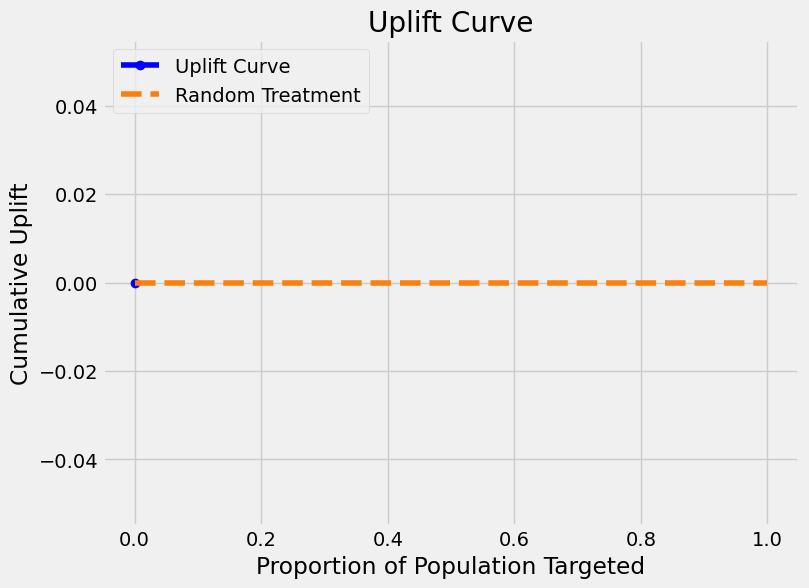

In [7]:
# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [225]:

auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
# auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
#            n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

ite       0.623534
bin       0.465670
Random    0.490255
dtype: float64

In [48]:
#C = df_test_sorted.where("treatment == 0").count()
T = df_test_sorted.where("treatment != 0").count()
T

24/11/12 04:54:20 WARN TaskSetManager: Stage 106 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.


1387569

In [47]:
# Calculate the number of control and treatment samples
C = df_test_sorted.where("treatment == 0").count()
T = df_test_sorted.where("treatment != 0").count()

# Add columns to the DataFrame to calculate the control and treatment cumulative sum
df_test_ranked = (
    df_test_sorted.withColumn(
        "control_label",
        F.when(F.col('treatment') == 0, F.col('visit')).otherwise(0),
    )
    .withColumn(
        "treatment_label",
        F.when(F.col('treatment') != 0, F.col('visit')).otherwise(0),
    )
    .withColumn(
        "control_cumsum",
        F.sum("control_label").over(Window.orderBy("percent_rank")) / C,
    )
    .withColumn(
        "treatment_cumsum",
        F.sum("treatment_label").over(Window.orderBy("percent_rank")) / T,
    )
)

# Display the first 20 rows of the dataframe
display(df_test_ranked.limit(10).toPandas())

24/11/12 04:47:05 WARN TaskSetManager: Stage 79 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.
24/11/12 04:47:32 WARN TaskSetManager: Stage 88 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.
24/11/12 04:47:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 04:47:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 04:47:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 04:47:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/12 04:47:35 WARN WindowExec: No Partition Defined 

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,treatment,conversion,visit,exposure,ite,percent_rank,control_label,treatment_label,control_cumsum,treatment_cumsum
0,12.632704,10.059654,8.333584,2.587543,10.280525,4.115453,-3.993764,4.833815,3.920995,22.570329,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
1,12.616365,10.059654,8.837823,4.679882,10.280525,4.115453,0.294443,4.833815,3.927254,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
2,22.605250,10.059654,8.465308,4.679882,10.280525,4.115453,-9.404879,4.833815,3.835145,18.380112,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
3,23.130760,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
4,12.616365,10.059654,8.924308,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
5,22.213951,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
6,22.203386,10.059654,8.214383,4.679882,10.280525,4.115453,-8.693224,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,0.0
7,22.584338,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,...,1,0,0,0,0.172211,0.000005,0,0,NaN,0.0
8,22.500326,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,...,1,0,0,0,0.167937,0.000006,0,0,NaN,0.0
9,23.047840,10.059654,8.214383,4.679882,10.280525,4.115453,-9.717309,4.833815,3.971858,13.190056,...,1,0,0,0,0.167937,0.000006,0,0,NaN,0.0


In [226]:
# run for loop to find hyperparameters
max_depth_values = [3, 4, 5, 6, 10]
learning_rate_values = [0.1, 0.5, 1]
reg_lambda_values = [0, 1, 2]

In [229]:
results = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
            t_learner.fit(X_train, T_train, y_train)
            ite_test = t_learner.predict(X_test)
            ite_test = [value[0] for value in ite_test]
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results = pd.concat([results, this_result], axis=0)

results.sort_values(by='auuc', ascending=False)
display(results.head(3))

,max_depth,learning_rate,reg_lambda,auuc
0,3.0,0.1,0.0,0.636175
0,3.0,0.1,1.0,0.634141
0,3.0,0.1,2.0,0.638739


## Copy tutorial

In [88]:
classifier = (
    LightGBMClassifier(dataTransferMode="bulk")
    .setFeaturesCol("features")  # Set the column name for features
    .setNumLeaves(10)  # Set the number of leaves in each decision tree
    .setNumIterations(100)  # Set the number of boosting iterations
    .setObjective("binary")  # Set the objective function for binary classification
    .setLabelCol(LABEL_COLUMN)  # Set the column name for the label
)

# Start a new MLflow run with the name "uplift"
active_run = mlflow.start_run(run_name="uplift")

# Start a new nested MLflow run with the name "treatment"
with mlflow.start_run(run_name="treatment", nested=True) as treatment_run:
    treatment_run_id = treatment_run.info.run_id  # Get the ID of the treatment run
    treatment_model = classifier.fit(treatment_train_df)  # Fit the classifier on the treatment training data

# Start a new nested MLflow run with the name "control"
with mlflow.start_run(run_name="control", nested=True) as control_run:
    control_run_id = control_run.info.run_id  # Get the ID of the control run
    control_model = classifier.fit(control_train_df)  # Fit the classifier on the control training data

NameError: name 'LightGBMClassifier' is not defined

In [87]:
from pyspark.sql.types import *
getPred = F.udf(lambda v: float(v[1]), FloatType())

# Cache the resulting DataFrame for easier access
test_pred_df = (
    test_df.mlTransform(treatment_model)
    .withColumn("treatment_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .mlTransform(control_model)
    .withColumn("control_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .withColumn("pred_uplift", F.col("treatment_pred") - F.col("control_pred"))
    .select(TREATMENT_COLUMN, LABEL_COLUMN, "treatment_pred", "control_pred", "pred_uplift")
    .cache()
)

# Display the first twenty rows of the resulting DataFrame
display(test_pred_df.limit(20))

NameError: name 'test_df' is not defined

## Run again with best parameter setting

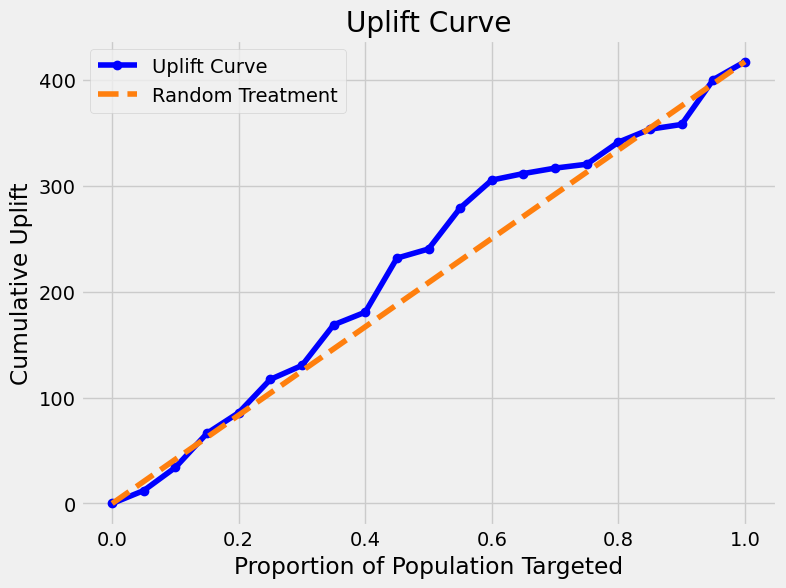

In [230]:
max_depth = 3
learning_rate = 0.1
reg_lambda = 0

t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
t_learner.fit(X_train, T_train, y_train)
ite_test = t_learner.predict(X_test)
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
df_test_sorted = df_test.sort_values(by='ite', ascending=False)

# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [294]:
# following Microsoft's way
treated = df_test_sorted.query('treatment == 1')
control = df_test_sorted.query('treatment == 0')
df_test_sorted['treatment_cumsum'] = treated['outcome'].cumsum() / len(treated)
df_test_sorted['control_cumsum'] = control['outcome'].cumsum() / len(control)
df_test_sorted = df_test_sorted.ffill().fillna(0) # fill in NA values for treatment and control for observations of the opposite sign

In [295]:
df_test_sorted['percent_rank'] = df_test_sorted['ite'].rank(pct=True, ascending=False)
df_test_sorted['uplift'] = df_test_sorted['treatment_cumsum'] - df_test_sorted['control_cumsum']
df_test_sorted.tail(20)

,treatment,ite,outcome,treatment_cumsum,control_cumsum,percent_rank,uplift
12408,1,-0.093968,1,0.152894,0.104818,0.997775,0.048077
25902,1,-0.094278,0,0.152894,0.104818,0.997951,0.048077
8296,1,-0.094278,1,0.153128,0.104818,0.997951,0.048310
12979,1,-0.094384,0,0.153128,0.104818,0.998126,0.048310
63442,1,-0.098651,0,0.153128,0.104818,0.998243,0.048310
13802,0,-0.101813,0,0.153128,0.104818,0.998360,0.048310
4751,1,-0.107938,0,0.153128,0.104818,0.998478,0.048310
54928,1,-0.108624,1,0.153361,0.104818,0.998595,0.048543
57604,1,-0.110840,0,0.153361,0.104818,0.998712,0.048543
38612,0,-0.118890,0,0.153361,0.104818,0.998829,0.048543


In [296]:
x_axis = [val for val in df_test_sorted['percent_rank'].values]
y_axis = [val for val in df_test_sorted['uplift'].values]

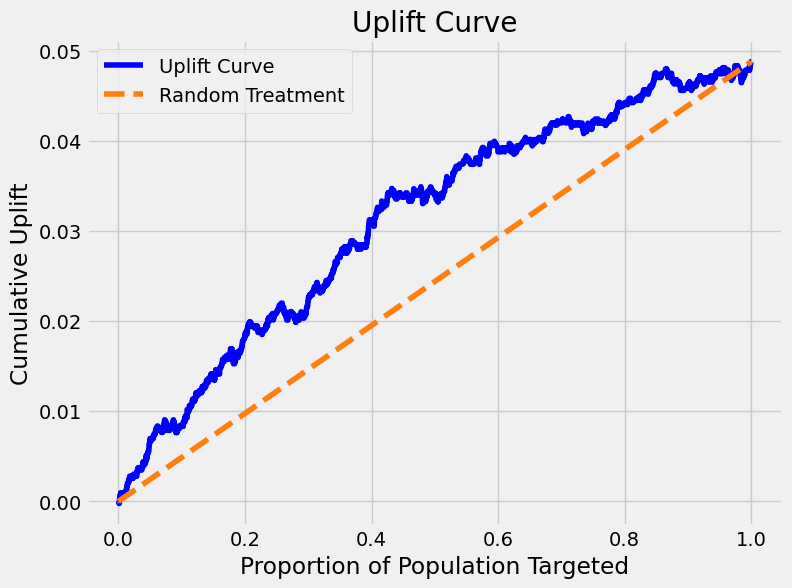

In [297]:
# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    x_axis, 
    y_axis, 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(x_axis)],
    [0, max(y_axis)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

We will want to target around the first 20% or 45% of the population, as these have the largest distance from the random treatment curve resulting in highest yielding gain

# Causal Inference in Marketing

In [37]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, mean
from pyspark.sql.types import StructType, StructField, FloatType
from pyspark.sql.window import Window
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g --executor-memory 8g pyspark-shell"

from causalml.inference.meta import BaseTClassifier
from causalml.metrics.visualize import plot, auuc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from econml.metalearners import TLearner
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
spark = SparkSession.builder.appName("Load data").getOrCreate()
df = spark.read.csv("data/criteo-uplift-v2.1.csv", header=True, inferSchema=True)
df_10 = spark.read.csv("data/criteo-uplift-10k.csv", header=True, inferSchema=True)
n = df_10.count()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/11 01:46:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read in and Prep Data

In [17]:
n = df.count()
n

13979592

In [4]:
#df_1 = df.limit(5000)
#df_2 = df.orderBy("treatment", ascending=True).limit(5000)
#df_3 = df_1.union(df_2)
#df_3 = df_3.toPandas()
#df_3 = pd.concat([df_1, df_2], axis=0)
#df_3.to_csv("data/criteo-uplift-10k.csv", index=False)

In [6]:
df.limit(3).toPandas()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [100]:
# convert categorical columns to binaries
# zip_code_dummies = pd.get_dummies(df['zip_code'], prefix='zip_code')*1
# channel_dummies = pd.get_dummies(df['channel'], prefix='channel')*1
# df = pd.concat([df, zip_code_dummies, channel_dummies], axis=1)
# df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1,0,1,0,0,1,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,1,0,0,0,0,1
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1,0,1,0,0,0,1


In [19]:
# Filter for control group and calculate visit and conversion rates
control_df = df.filter(col("treatment") == 0)
control_visit_rate = control_df.agg(mean("visit")).collect()[0][0]
control_conversion_rate = control_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Filter for treatment group and calculate visit and conversion rates
treatment_df = df.filter(col("treatment") == 1)
treatment_visit_rate = treatment_df.agg(mean("visit")).collect()[0][0]
treatment_conversion_rate = treatment_df.filter(col("visit") == 1).agg(mean("conversion")).collect()[0][0]

# Print the results
print(f"The control group had an {round(control_visit_rate, 4)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 4)*100}% conversion rate")
print(f"The treatment group had a {round(treatment_visit_rate, 4)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 4)*100}% conversion rate")

The control group had an 3.82% visit rate, of these visits there was a 5.07% conversion rate
The treatment group had a 4.8500000000000005% visit rate, of these visits there was a 6.36% conversion rate


In [101]:
#control_visit_rate = df.query("treatment == 0")['visit'].mean()
#control_conversion_rate = df.query("treatment == 0 and visit == 1")['conversion'].mean()
#print(f"The control group had an {round(control_visit_rate, 2)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 2)*100}% conversion rate")

#treatment_visit_rate = df.query("treatment == 1")['visit'].mean()
#treatment_conversion_rate = df.query("treatment == 1 and visit == 1")['conversion'].mean()
#print(f"The treatment group had a {round(treatment_visit_rate, 2)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 2)*100}% conversion rate")

The control group had an 11.0% visit rate, of these visits there was a 5.0% conversion rate
The treatment group had a 15.0% visit rate, of these visits there was a 6.0% conversion rate


In [25]:
df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)
#features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
features = ['f1','f2','f3','f10','f11']
X_train = df_train[features]; X_test = df_test[features];
T_train = df_train[["treatment"]]; T_test = df_test[["treatment"]];
y_train = df_train[["visit"]]; y_test = df_test[["visit"]];

In [37]:
#y_train_pd = y_train.toPandas()
#T_train_pd = T_train.toPandas()
X_train_pd = X_train.toPandas()

Py4JJavaError: An error occurred while calling o490.collectToPython.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:102)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:455)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:498)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:345)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:364)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:445)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at jdk.internal.reflect.GeneratedMethodAccessor75.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [217]:
# Features, treatment, and outcome
#X = df[['recency', 'history', 'womens', 'zip_code_Rural', 'zip_code_Urban', 'channel_Web']]
#T = df['treatment']
#y = df['visit']

In [31]:
# Split the data into train and test
#X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)

In [10]:
T_train.describe().show()

+-------+------------------+
|summary|         treatment|
+-------+------------------+
|  count|          11183688|
|   mean|0.8499596912932478|
| stddev|0.3571109433677313|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [4]:
# fit the EconML model
models = GradientBoostingRegressor(n_estimators=10, max_depth=6, min_samples_leaf=100)
t_learner_eml = TLearner(models=models)
# Train T_learner
#t_learner_eml.fit(y_train_pd, T_train_pd, X=X_train.collect())
t_learner_eml.fit(y_train.collect(), T_train.collect(), X=X_train.collect())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [25]:
# Fit the CausalML model
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
#t_learner_cml = BaseTClassifier(learner=XGBClassifier(max_depth=3, learning_rate = 0.2, reg_lambda = 0.2, random_state=42))
#t_learner_cml.fit(X_train.collect(), T_train.collect(), y_train.collect())

In [20]:
ite_test = t_learner_eml.effect(X_test.collect())
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test.toPandas()["treatment"], "ite": ite_test, "outcome": y_test.toPandas()["visit"]})
df_test.head()

,treatment,ite,outcome
0,1,0.003742,0
1,1,0.003742,0
2,1,0.003742,0
3,1,0.003742,0
4,1,0.003742,0


In [29]:
T_test["treatment"]

Column<'treatment'>

In [34]:
ite_test = t_learner_eml.effect(X_test.collect())
ite_test = [float(value[0]) for value in ite_test]
ite_schema = StructType([StructField("ite", FloatType(), True)])
df_ite = spark.createDataFrame([(v,) for v in ite_test], schema=ite_schema)
df_test = df_test.withColumn("row_index", F.monotonically_increasing_id())
df_ite = df_ite.withColumn("row_index", F.monotonically_increasing_id())
df_test = df_test.join(df_ite, "row_index").drop("row_index")
df_test.limit(3).toPandas()

24/11/11 15:14:00 WARN TaskSetManager: Stage 22 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,ite
0,12.616365,10.059654,8.214383,4.679882,10.280525,0.346360,0.294443,10.655268,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
1,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,9.323430,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742
2,12.616365,10.059654,8.214383,4.679882,10.280525,2.230907,0.294443,11.244340,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.003742


## Uplift curve
Let's make the uplift curve, note while this looks similar to the AUC curve, it is different. The x-axis in this case represents the population selected for treatment. So at the origin when x = 0, this is when we do not give treatment to anybody; in contrast when x = 1, this is when we give treatment to everybody. The y-axis measures the uplift between the difference of predicted treatment and control outcomes. A standard thing to do, is to also sort the individuals so that the highest uplift individuals have their uplift recorded first (by sorting them from highest uplift to lowest) which will give the curve the concave shape when it out performs the baseline random treatment assignment model

In [38]:
# Sort the test data by uplift score in descending order
#df_test_sorted = df_test.sort_values(by='ite', ascending=False)
#df_test_sorted.head(6)
# Compute the percentage rank of the predicted uplift values in descending order, and display the top twenty rows
df_test_sorted = df_test.withColumn("percent_rank", F.percent_rank().over(Window.orderBy(F.desc("ite"))))

display(df_test_sorted.limit(10).toPandas())

24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:11 WARN TaskSetManager: Stage 27 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.
24/11/11 16:04:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:04:13 WARN WindowExec

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,ite,percent_rank
0,12.632704,10.059654,8.333584,2.587543,10.280525,4.115453,-3.993764,4.833815,3.920995,22.570329,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
1,12.616365,10.059654,8.837823,4.679882,10.280525,4.115453,0.294443,4.833815,3.927254,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
2,22.605250,10.059654,8.465308,4.679882,10.280525,4.115453,-9.404879,4.833815,3.835145,18.380112,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
3,23.130760,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
4,12.616365,10.059654,8.924308,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
5,22.213951,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
6,22.203386,10.059654,8.214383,4.679882,10.280525,4.115453,-8.693224,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.175915,0.000000
7,22.584338,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.172211,0.000005
8,22.500326,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.167937,0.000006
9,23.047840,10.059654,8.214383,4.679882,10.280525,4.115453,-9.717309,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.167937,0.000006


In [11]:
df_test_sorted.tail(2)

,treatment,ite,outcome,bin
1520336,1,-0.09276,1,7
1042442,1,-0.09276,0,4


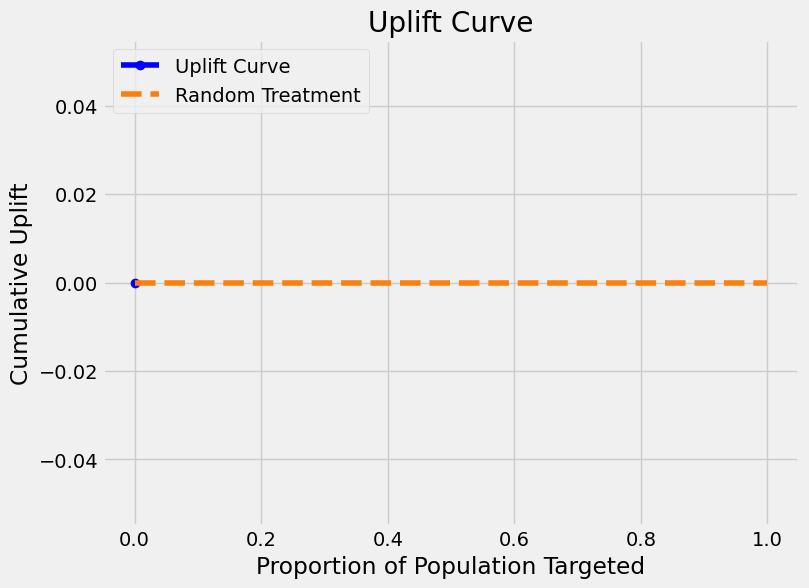

In [7]:
# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [225]:

auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
# auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
#            n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

ite       0.623534
bin       0.465670
Random    0.490255
dtype: float64

In [41]:
# Calculate the number of control and treatment samples
C = df_test_sorted.where(f"'treatment' == 0").count()
T = df_test_sorted.where("'treatment' != 0").count()

# Add columns to the DataFrame to calculate the control and treatment cumulative sum
test_ranked_df = (
    df_test_sorted.withColumn(
        "control_label",
        F.when(F.col('treatment') == 0, F.col('visit')).otherwise(0),
    )
    .withColumn(
        "treatment_label",
        F.when(F.col('treatment') != 0, F.col('visit')).otherwise(0),
    )
    .withColumn(
        "control_cumsum",
        F.sum("control_label").over(Window.orderBy("percent_rank")) / C,
    )
    .withColumn(
        "treatment_cumsum",
        F.sum("treatment_label").over(Window.orderBy("percent_rank")) / T,
    )
)

# Display the first 20 rows of the dataframe
display(test_ranked_df.limit(10).toPandas())

24/11/11 16:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/11 16:06:09 WARN TaskSetManager: Stage 44 contains a task of very large size (5654 KiB). The maximum recommended task size is 1000 KiB.
24/11/11 16:06:11 WARN WindowExec

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,treatment,conversion,visit,exposure,ite,percent_rank,control_label,treatment_label,control_cumsum,treatment_cumsum
0,12.632704,10.059654,8.333584,2.587543,10.280525,4.115453,-3.993764,4.833815,3.920995,22.570329,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
1,12.616365,10.059654,8.837823,4.679882,10.280525,4.115453,0.294443,4.833815,3.927254,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
2,22.605250,10.059654,8.465308,4.679882,10.280525,4.115453,-9.404879,4.833815,3.835145,18.380112,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
3,23.130760,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
4,12.616365,10.059654,8.924308,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
5,22.213951,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
6,22.203386,10.059654,8.214383,4.679882,10.280525,4.115453,-8.693224,4.833815,3.971858,13.190056,...,1,0,0,0,0.175915,0.000000,0,0,NaN,NaN
7,22.584338,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,...,1,0,0,0,0.172211,0.000005,0,0,NaN,NaN
8,22.500326,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,...,1,0,0,0,0.167937,0.000006,0,0,NaN,NaN
9,23.047840,10.059654,8.214383,4.679882,10.280525,4.115453,-9.717309,4.833815,3.971858,13.190056,...,1,0,0,0,0.167937,0.000006,0,0,NaN,NaN


In [226]:
# run for loop to find hyperparameters
max_depth_values = [3, 4, 5, 6, 10]
learning_rate_values = [0.1, 0.5, 1]
reg_lambda_values = [0, 1, 2]

In [229]:
results = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
            t_learner.fit(X_train, T_train, y_train)
            ite_test = t_learner.predict(X_test)
            ite_test = [value[0] for value in ite_test]
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results = pd.concat([results, this_result], axis=0)

results.sort_values(by='auuc', ascending=False)
display(results.head(3))

,max_depth,learning_rate,reg_lambda,auuc
0,3.0,0.1,0.0,0.636175
0,3.0,0.1,1.0,0.634141
0,3.0,0.1,2.0,0.638739


## Copy tutorial

In [88]:
classifier = (
    LightGBMClassifier(dataTransferMode="bulk")
    .setFeaturesCol("features")  # Set the column name for features
    .setNumLeaves(10)  # Set the number of leaves in each decision tree
    .setNumIterations(100)  # Set the number of boosting iterations
    .setObjective("binary")  # Set the objective function for binary classification
    .setLabelCol(LABEL_COLUMN)  # Set the column name for the label
)

# Start a new MLflow run with the name "uplift"
active_run = mlflow.start_run(run_name="uplift")

# Start a new nested MLflow run with the name "treatment"
with mlflow.start_run(run_name="treatment", nested=True) as treatment_run:
    treatment_run_id = treatment_run.info.run_id  # Get the ID of the treatment run
    treatment_model = classifier.fit(treatment_train_df)  # Fit the classifier on the treatment training data

# Start a new nested MLflow run with the name "control"
with mlflow.start_run(run_name="control", nested=True) as control_run:
    control_run_id = control_run.info.run_id  # Get the ID of the control run
    control_model = classifier.fit(control_train_df)  # Fit the classifier on the control training data

NameError: name 'LightGBMClassifier' is not defined

In [87]:
from pyspark.sql.types import *
getPred = F.udf(lambda v: float(v[1]), FloatType())

# Cache the resulting DataFrame for easier access
test_pred_df = (
    test_df.mlTransform(treatment_model)
    .withColumn("treatment_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .mlTransform(control_model)
    .withColumn("control_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .withColumn("pred_uplift", F.col("treatment_pred") - F.col("control_pred"))
    .select(TREATMENT_COLUMN, LABEL_COLUMN, "treatment_pred", "control_pred", "pred_uplift")
    .cache()
)

# Display the first twenty rows of the resulting DataFrame
display(test_pred_df.limit(20))

NameError: name 'test_df' is not defined

## Run again with best parameter setting

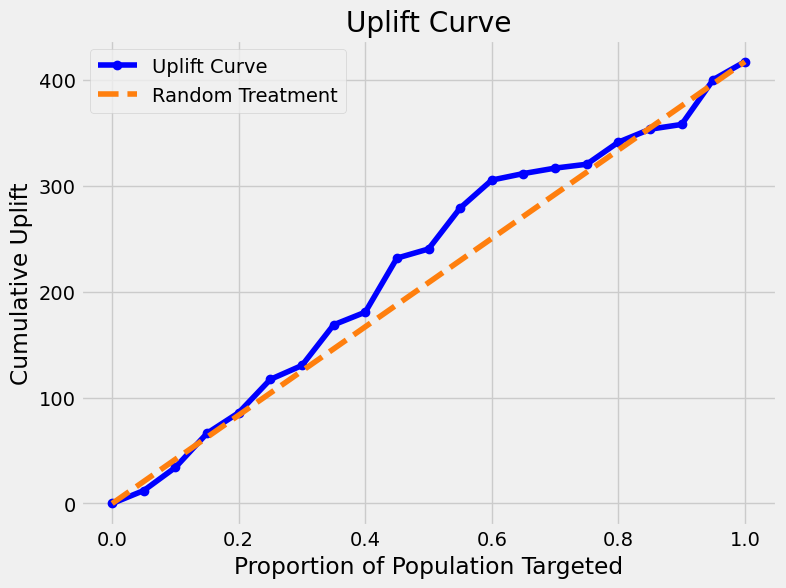

In [230]:
max_depth = 3
learning_rate = 0.1
reg_lambda = 0

t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
t_learner.fit(X_train, T_train, y_train)
ite_test = t_learner.predict(X_test)
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
df_test_sorted = df_test.sort_values(by='ite', ascending=False)

# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [294]:
# following Microsoft's way
treated = df_test_sorted.query('treatment == 1')
control = df_test_sorted.query('treatment == 0')
df_test_sorted['treatment_cumsum'] = treated['outcome'].cumsum() / len(treated)
df_test_sorted['control_cumsum'] = control['outcome'].cumsum() / len(control)
df_test_sorted = df_test_sorted.ffill().fillna(0) # fill in NA values for treatment and control for observations of the opposite sign

In [295]:
df_test_sorted['percent_rank'] = df_test_sorted['ite'].rank(pct=True, ascending=False)
df_test_sorted['uplift'] = df_test_sorted['treatment_cumsum'] - df_test_sorted['control_cumsum']
df_test_sorted.tail(20)

,treatment,ite,outcome,treatment_cumsum,control_cumsum,percent_rank,uplift
12408,1,-0.093968,1,0.152894,0.104818,0.997775,0.048077
25902,1,-0.094278,0,0.152894,0.104818,0.997951,0.048077
8296,1,-0.094278,1,0.153128,0.104818,0.997951,0.048310
12979,1,-0.094384,0,0.153128,0.104818,0.998126,0.048310
63442,1,-0.098651,0,0.153128,0.104818,0.998243,0.048310
13802,0,-0.101813,0,0.153128,0.104818,0.998360,0.048310
4751,1,-0.107938,0,0.153128,0.104818,0.998478,0.048310
54928,1,-0.108624,1,0.153361,0.104818,0.998595,0.048543
57604,1,-0.110840,0,0.153361,0.104818,0.998712,0.048543
38612,0,-0.118890,0,0.153361,0.104818,0.998829,0.048543


In [296]:
x_axis = [val for val in df_test_sorted['percent_rank'].values]
y_axis = [val for val in df_test_sorted['uplift'].values]

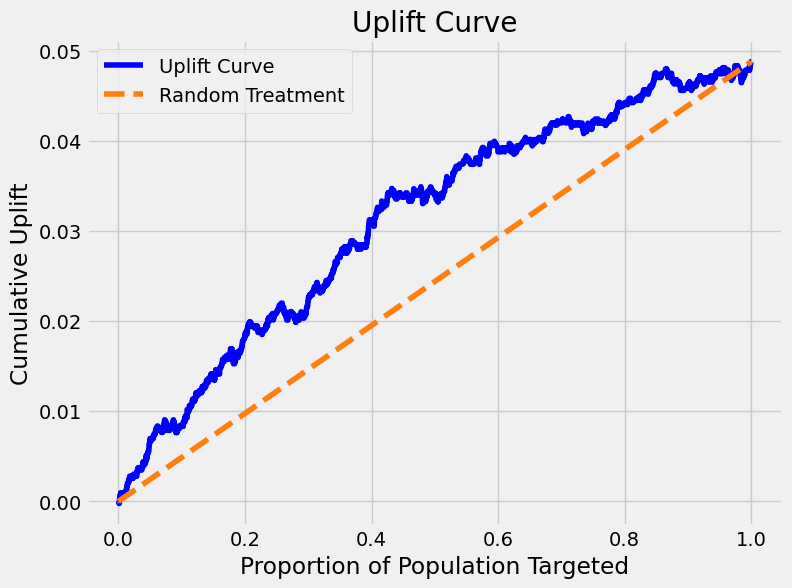

In [297]:
# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    x_axis, 
    y_axis, 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(x_axis)],
    [0, max(y_axis)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

We will want to target around the first 20% or 45% of the population, as these have the largest distance from the random treatment curve resulting in highest yielding gain